# Idneo code

In [1]:
import os

os.chdir("..")

In [2]:
%pip install -r tools/vehicle/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [81]:
import pandas as pd
from tools.vehicle.src.csv_parser import proccess_csv
from tools.vehicle.src.data_handler import order_by_ts_relative
import matplotlib.pyplot as plt
import argparse
import time
import redis
from lightgbm import LGBMClassifier
import pandas as pd
import ast
import redis
from influxdb_client import InfluxDBClient, BucketsApi, Point
from influxdb_client.client.organizations_api import OrganizationsApi
from influxdb_client.client.write_api import SYNCHRONOUS

In [4]:
data_sets = [
    "DS1_stopped_with_ignition_on_22Feb24_115812.csv",
    "DS1_stopped_with_ignition_on_25Jan24_124019.csv",
    "DS1_stopped_with_ignition_on_25Jan24_151531.csv",
    "DS1_stopped_with_ignition_on_25Mar24_153740.CSV",
    "DS2_national_road_90km_h_max_25Jan24_153019.csv",
    "DS2_national_road_90km_h_max_25Mar24_133516.CSV",
    "DS3_highway_120km_h_max_22Feb24_121145.csv",
    "DS3_highway_120km_h_max_25Mar24_154857.csv",
]
file = "tools/vehicle/datasets/ateca_R4_2.0l_TDI/" + data_sets[0]
# Pre-process csv dataset
data_ordered_by_sensor = proccess_csv(file)

# Timestamp sorting
data_ordered_by_time = order_by_ts_relative(data_ordered_by_sensor)

['Vehicle speed', 'Time since engine start', 'Normed load value', 'Accelerator pedal position', 'Engine torque', 'Oil fill level', 'Engine oil temperature', 'Fuel level', 'Fuel consumption', 'Brake pressure', 'Engaged gear: raw signal-Bits 0-7', 'Efficiency of the SCR catalytic converter']
Dataset has begun after  0 seconds...


In [5]:
data_ordered_by_sensor[0].keys()

dict_keys(['sensor', 'unit', 'values'])

In [6]:
data_ordered_by_sensor[0]["sensor"], data_ordered_by_sensor[0][
    "unit"
], data_ordered_by_sensor[0]["values"][:5]

('Vehicle_speed',
 ' km/h',
 [{'ts_relative': 1.74, 'value': 0.0},
  {'ts_relative': 3.19, 'value': 0.0},
  {'ts_relative': 4.69, 'value': 0.0},
  {'ts_relative': 6.17, 'value': 0.0},
  {'ts_relative': 7.61, 'value': 0.0}])

In [7]:
data_ordered_by_time[:5]

[{0.14: {'sensor': 'Efficiency_of_the_SCR_catalytic_converter', 'value': 0.0}},
 {0.36: {'sensor': 'Time_since_engine_start', 'value': 0.0}},
 {0.46: {'sensor': 'Normed_load_value', 'value': 23.1}},
 {0.57: {'sensor': 'Accelerator_pedal_position', 'value': 14.5}},
 {0.69: {'sensor': 'Engine_torque', 'value': 48.4}}]

In [32]:
df = pd.read_csv(file)

In [33]:
df.head()

,Unnamed: 0,STAMP,Vehicle speed,STAMP.1,Time since engine start,STAMP.2,Normed load value,STAMP.3,Accelerator pedal position,STAMP.4,...,Fuel level,STAMP.8,Fuel consumption,STAMP.9,Brake pressure,STAMP.10,Engaged gear: raw signal-Bits 0-7,STAMP.11,Efficiency of the SCR catalytic converter,Unnamed: 25
0,NaN,NaN,km/h,NaN,s,NaN,%,NaN,%,NaN,...,l,NaN,l/h,NaN,MPa,NaN,,NaN,,NaN
1,NaN,0.24,0,0.36,0,0.46,23.1,0.57,14.5,0.69,...,24.00,1.23,1.15,1.35,3.63,1.49,0,0.14,0.00000,NaN
2,NaN,1.74,0,1.86,1,1.95,32.5,2.07,14.5,2.19,...,24.00,2.69,1.19,2.81,3.63,2.95,0,1.64,0.00000,NaN
3,NaN,3.19,0,3.28,3,3.39,41.2,3.50,14.5,3.62,...,24.00,4.16,1.15,4.30,3.54,4.43,0,3.09,0.00000,NaN
4,NaN,4.69,0,4.80,4,4.91,34.9,5.02,14.5,5.15,...,24.00,5.68,1.07,5.80,3.51,5.93,0,4.58,0.00363,NaN


In [34]:
df.drop(columns=["Unnamed: 0", "Unnamed: 25"], inplace=True)
df.drop(index=0, inplace=True)

In [35]:
timestamp_columns = [col for col in df.columns if col.startswith("STAMP")]

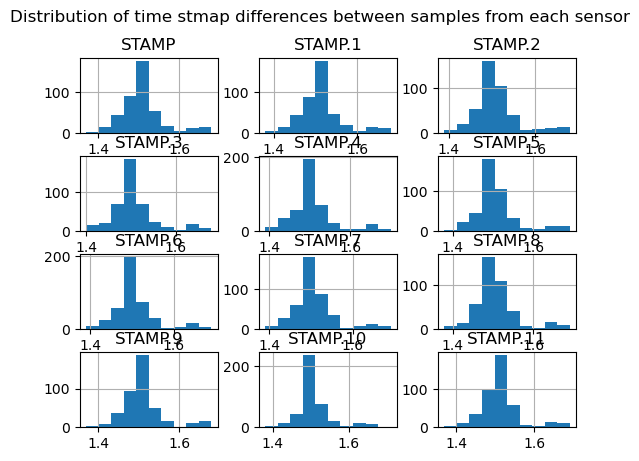

In [36]:
df[timestamp_columns].diff().hist()
plt.suptitle("Distribution of time stmap differences between samples from each sensor");

## Check if the timestamp values are not overlapping
Chce if the data format is correct and the data could be used in "tabular chunks" for prediction in the model, i.e. if the maximum timestamp in each row is lower than the minimum timestamp in the following row

In [37]:
temp = df[timestamp_columns].min(axis=1)[1:].reset_index(drop=True) - df[
    timestamp_columns
].max(axis=1)[:-1].reset_index(drop=True)

In [38]:
(temp > 0).sum()

428

In [39]:
(temp <= 0).sum()

0

## Model

### Add some class to train the model

In [40]:
df_train = df.drop(columns=timestamp_columns)
# keep only the first timestamp column
df_train["timestamp"] = df["STAMP"]
df_train["class"] = 0
df_train.loc[:100, ["class"]] = 1
df_train.loc[:100, ["Normed load value"]] = 100

In [ ]:
df_train[df_train.drop(columns=["class"]).columns] = df_train[
    df_train.drop(columns=["class"]).columns
].astype(float)

In [ ]:
# Remove special characters from column names
df_train.columns = df_train.columns.str.replace("[^A-Za-z0-9]+", "_", regex=True)

In [51]:
# add some vehicle id
df_train["vehicle_id"] = "abc123"

### Train the model

In [52]:
model = LGBMClassifier()
model.fit(
    df_train.drop(columns=["class", "timestamp", "vehicle_id"]), df_train["class"]
)

[LightGBM] [Info] Number of positive: 100, number of negative: 329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 429, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.233100 -> initscore=-1.190888
[LightGBM] [Info] Start training from score -1.190888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

LGBMClassifier()

In [117]:
df_pred = df_train.iloc[95:105][["timestamp", "vehicle_id"]].reset_index(drop=True)
df_pred["prediction"] = model.predict(
    df_train.iloc[95:105]
    .drop(columns=["class", "timestamp", "vehicle_id"])
    .reset_index(drop=True)
)

df_pred["timestamp"] = pd.to_datetime(
    time.time() - 3600 + df_pred["timestamp"], unit="s"
)

In [118]:
df_pred

,timestamp,vehicle_id,prediction
0,2024-07-30 11:56:40.044199467,abc123,1
1,2024-07-30 11:56:41.464199305,abc123,1
2,2024-07-30 11:56:42.954199314,abc123,1
3,2024-07-30 11:56:44.474199295,abc123,1
4,2024-07-30 11:56:45.914199352,abc123,1
5,2024-07-30 11:56:47.334199429,abc123,0
6,2024-07-30 11:56:48.894199371,abc123,0
7,2024-07-30 11:56:50.384199381,abc123,0
8,2024-07-30 11:56:51.864199400,abc123,0
9,2024-07-30 11:56:53.384199381,abc123,0


In [120]:
# # https://github.com/influxdata/helm-charts/blob/master/charts/influxdb2/values.yaml
# INFLUXDB_IP = "10.152.183.219"
# INFLUXDB_PORT = 80
# INFLUXDB_USER = "admin"
# INFLUXDB_PASS = "admin_pass"

# influxdbClient = InfluxDBClient(url=f"http://{INFLUXDB_IP}:{str(INFLUXDB_PORT)}", username=INFLUXDB_USER, password=INFLUXDB_PASS, org="influxdata")
# # influxdbClient = InfluxDBClient(url=f"http://{INFLUXDB_IP}:{str(INFLUXDB_PORT)}", token="admin_token", org="influxdata")

# write_api = influxdbClient.write_api(write_options=SYNCHRONOUS)

# Function to convert a DataFrame row to an InfluxDB Point
def df_row_to_point(row):
    return (
        Point("prediction")
        .tag("vehicle_id", row["vehicle_id"])
        .field("value", row["prediction"])
        .time(row["timestamp"])
    )


# Convert DataFrame to InfluxDB Points and write
points = [df_row_to_point(row) for index, row in df_pred.iterrows()]

# Write points to InfluxDB
write_api.write(bucket="default", record=points)

## Query/collect data from redis and send it to influxdb
This is a case when the data is not forwarded directly to inference service, i.e. legacy solution made due to previous agreements in the project

### Subcsribe to channel and define actions

In [65]:
REDIS_PASSWORD = "redis"
REDIS_IP = "10.152.183.169"
REDIS_PORT = 6379
INFLUXDB_IP = "10.152.183.216"
INFLUXDB_PORT = 8086
INFLUXDB_USER = "admin"
INFLUXDB_PASS = "admin"

redisClient = redis.Redis(host=REDIS_IP, password=REDIS_PASSWORD, port=REDIS_PORT)
influxdbClient = InfluxDBClient(
    url=f"http://{INFLUXDB_PORT}:{str(INFLUXDB_PORT)}",
    username=INFLUXDB_USER,
    password=INFLUXDB_PASS,
)


def handle_message(message):
    print(f"New data arrived:\n{message['data']}")
    # Convert the message data (bytes) to string
    json_data = message["data"].decode("utf-8")
    # Convert JSON string to DataFrame
    df = pd.read_json(json_data, orient="split")
    print(df)
    df_pred = model.predict(df.drop(columns=["class", "timestamp", "vehicle_id"]))
    print(f"Predictions:\n{df_pred}")


# Subscribe to the "idneo_v2x" channel
pubsub = redisClient.pubsub()
pubsub.subscribe(**{"idneo_v2x": handle_message})

# Wait for messages
pubsub.run_in_thread(sleep_time=1)

<PubSubWorkerThread(Thread-6, started 128202013926976)>

### Publish the data into the channel and make predictions

In [ ]:
df_test_json = df_train.iloc[95:105].reset_index(drop=True).to_json(orient="split")


time.sleep(2)  # Wait for a few seconds before publishing
redisClient.publish("idneo_v2x", df_test_json)

## Send predictions to InfluxDB
* https://www.influxdata.com/blog/writing-data-to-influxdb-with-python/
* https://gist.github.com/noahcrowley/941e87422cd6fc43b0e9e8f0d0877836/#file-write_test-py